In [1]:
import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets.mnist
from torchvision import transforms
from tqdm import tqdm

In [2]:
do_learn = True
save_frequency = 2
batch_size = 16
lr = 0.001
num_epochs = 10
weight_decay = 0.0001

In [3]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [4]:
def read_label_file(path):
   with open(path, 'rb') as f:
      data = f.read()
   assert get_int(data[:4]) == 2049
   length = get_int(data[4:8])
   parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
   return torch.from_numpy(parsed).view(length).long()

In [5]:
def read_image_file(path):
   with open(path, 'rb') as f:
      data = f.read()
   assert get_int(data[:4]) == 2051
   length = get_int(data[4:8])
   num_rows = get_int(data[8:12])
   num_cols = get_int(data[12:16])
   images = []
   parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
   return torch.from_numpy(parsed).view(length, num_rows, num_cols)

In [6]:
class BalancedMNISTPair(torch.utils.data.Dataset):
   """Dataset that on each iteration provides two random pairs of
   MNIST images. One pair is of the same number (positive sample), one
   is of two different numbers (negative sample).
   """
   urls = [
      'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
      'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
      'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
      'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
   ]
   raw_folder = 'raw'
   processed_folder = 'processed'
   training_file = 'training.pt'
   test_file = 'test.pt'
   
   def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
      self.root = os.path.expanduser(root)
      self.transform = transform
      self.target_transform = target_transform
      self.train = train # training set or test set
      
      if download:
         self.download()
         
      if not self._check_exists():
         raise RuntimeError('Dataset not found.' + ' You can use download=True to download it')
         
      if self.train:
         self.train_data, self.train_labels = torch.load(
            os.path.join(self.root, self.processed_folder, self.training_file))
         
         train_labels_class = []
         train_data_class = []
         for i in range(10):
            indices = torch.squeeze((self.train_labels == i).nonzero())
            train_labels_class.append(torch.index_select(self.train_labels, 0, indices))
            train_data_class.append(torch.index_select(self.train_data, 0, indices))
            
         # generate balanced pairs
         self.train_data = []
         self.train_labels = []
         lengths = [x.shape[0] for x in train_labels_class]
         for i in range(10):
            for j in range(500): # create 500 pairs
               rnd_cls = random.randint(0,8) # choose random class that is not the same class
               if rnd_cls >= i:
                  rnd_cls = rnd_cls + 1

               rnd_dist = random.randint(0, 100)
                  
               self.train_data.append(torch.stack([train_data_class[i][j], train_data_class[i][j+rnd_dist], train_data_class[rnd_cls][j]]))
               self.train_labels.append([1,0])

         self.train_data = torch.stack(self.train_data)
         self.train_labels = torch.tensor(self.train_labels)
               
      else:
         self.test_data, self.test_labels = torch.load(
            os.path.join(self.root, self.processed_folder, self.test_file))
         
         test_labels_class = []
         test_data_class = []
         for i in range(10):
            indices = torch.squeeze((self.test_labels == i).nonzero())
            test_labels_class.append(torch.index_select(self.test_labels, 0, indices))
            test_data_class.append(torch.index_select(self.test_data, 0, indices))
            
         # generate balanced pairs
         self.test_data = []
         self.test_labels = []
         lengths = [x.shape[0] for x in test_labels_class]
         for i in range(10):
            for j in range(500): # create 500 pairs
               rnd_cls = random.randint(0,8) # choose random class that is not the same class
               if rnd_cls >= i:
                  rnd_cls = rnd_cls + 1

               rnd_dist = random.randint(0, 100)
                  
               self.test_data.append(torch.stack([test_data_class[i][j], test_data_class[i][j+rnd_dist], test_data_class[rnd_cls][j]]))
               self.test_labels.append([1,0])

         self.test_data = torch.stack(self.test_data)
         self.test_labels = torch.tensor(self.test_labels)
         
   def __getitem__(self, index):
      if self.train:
         imgs, target = self.train_data[index], self.train_labels[index]
      else:
         imgs, target = self.test_data[index], self.test_labels[index]
         
      img_ar = []
      for i in range(len(imgs)):
         img = Image.fromarray(imgs[i].numpy(), mode='L')
         if self.transform is not None:
            img = self.transform(img)
         img_ar.append(img)
         
      if self.target_transform is not None:
         target = self.target_transform(target)
         
      return img_ar, target
   
   def __len__(self):
      if self.train:
         return len(self.train_data)
      else:
         return len(self.test_data)
      
   def _check_exists(self):
      return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
         os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))
   
   def download(self):
      """Download the MNIST data if it doesn't exist in processed_folder already."""
      from six.moves import urllib
      import gzip

      if self._check_exists():
         return

      # download files
      try:
         os.makedirs(os.path.join(self.root, self.raw_folder))
         os.makedirs(os.path.join(self.root, self.processed_folder))
      except OSError as e:
         if e.errno == errno.EEXIST:
            pass
         else:
            raise

      for url in self.urls:
         print('Downloading ' + url)
         data = urllib.request.urlopen(url)
         filename = url.rpartition('/')[2]
         file_path = os.path.join(self.root, self.raw_folder, filename)
         with open(file_path, 'wb') as f:
            f.write(data.read())
         with open(file_path.replace('.gz', ''), 'wb') as out_f, \
               gzip.GzipFile(file_path) as zip_f:
            out_f.write(zip_f.read())
         os.unlink(file_path)

      # process and save as torch files
      print('Processing...')

      training_set = (
         read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte')),
         read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'))
      )
      test_set = (
         read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte')),
         read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'))
      )
      with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
         torch.save(training_set, f)
      with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
         torch.save(test_set, f)

      print('Done!')

   def __repr__(self):
      fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
      fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
      tmp = 'train' if self.train is True else 'test'
      fmt_str += '    Split: {}\n'.format(tmp)
      fmt_str += '    Root Location: {}\n'.format(self.root)
      tmp = '    Transforms (if any): '
      fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
      tmp = '    Target Transforms (if any): '
      fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
      return fmt_str
      

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        
    def forward(self, data):
        res = []
        for i in range(2):
            x = data[i]
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.dropout1(x)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            res.append(x)
        res = (1/2)*(F.kl_div(res[0], (res[0]+res[1])/2)) + \
        (1/2)*(F.kl_div(res[1], (res[0]+res[1])/2))
        return torch.abs(res)

In [8]:
class Net1(nn.Module):
   def __init__(self):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 64, 7)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(64, 128, 5)
      self.conv3 = nn.Conv2d(128, 256, 5)
      self.linear1 = nn.Linear(2304, 512)
      
      self.linear2 = nn.Linear(512, 2)
      
   def forward(self, data):
      res = []
      for i in range(2): # Siamese nets; sharing weights
         x = data[i]
         x = self.conv1(x)
         x = F.relu(x)
         x = self.pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.conv3(x)
         x = F.relu(x)
         
         x = x.view(x.shape[0], -1)
         x = self.linear1(x)
         res.append(F.relu(x))
         
      res = torch.abs(res[1] - res[0])
      res = self.linear2(res)
      return res

In [16]:
def train(model, device, train_loader, epoch, optimizer):
   model.train()
   
   for batch_idx, (data, target) in enumerate(train_loader):
      for i in range(len(data)):
         data[i] = data[i].to(device)
#       print(data[:2][0].shape)  
      optimizer.zero_grad()
      output_positive = model(data[:2])
      output_negative = model(data[0:3:2])
      
#       print(output_positive)
      
#       target = target.type(torch.LongTensor).to(device)
#       target_positive = torch.squeeze(1-target[:,0])
#       target_negative = torch.squeeze(1+target[:,1])
#       print(target_positive)
      
      loss_positive = F.mse_loss(output_positive, torch.tensor([0]).type(torch.FloatTensor).to(device))
      loss_negative = F.mse_loss(output_negative, torch.tensor([1]).type(torch.FloatTensor).to(device))
#       loss_positive = F.cross_entropy(output_positive, target_positive)
#       loss_negative = F.cross_entropy(output_negative, target_negative)
      
      loss = loss_positive + loss_negative
      loss.backward()
      
      optimizer.step()
      if batch_idx % 10 == 0:
         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx*batch_size, len(train_loader.dataset), 100. * batch_idx*batch_size / len(train_loader.dataset),
            loss.item()))

In [10]:
trans = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=True, download=True, transform=trans), batch_size=batch_size, shuffle=True)

In [11]:
a, b = iter(train_loader).next()

tensor([1, 0])


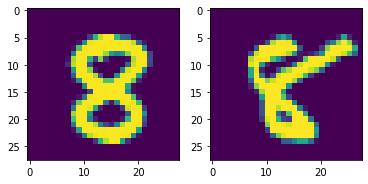

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('Horizontally stacked subplots')
ax1.imshow(a[0][4].numpy().squeeze());
ax2.imshow(a[1][4].numpy().squeeze());
print(b[1])

In [13]:
a[:2][0].shape

torch.Size([16, 1, 28, 28])

In [18]:
def test(model, device, test_loader):
   model.eval()
   
   with torch.no_grad():
      accurate_labels = 0
      all_labels = 0
      loss = 0
      for batch_idx, (data, target) in enumerate(test_loader):
         for i in range(len(data)):
            data[i] = data[i].to(device)
            
         output_positive = model(data[:2])
         output_negative = model(data[0:3:2])
            
#          target = target.type(torch.LongTensor).to(device)
#          target_positive = torch.squeeze(1-target[:,0])
#          target_negative = torch.squeeze(1+target[:,1])
            
         loss_positive = F.mse_loss(output_positive, torch.tensor([0]).type(torch.FloatTensor).to(device))
         loss_negative = F.mse_loss(output_negative, torch.tensor([1]).type(torch.FloatTensor).to(device))
            
         loss = loss + loss_positive + loss_negative
            
         accurate_labels_positive = torch.sum(torch.argmax(output_positive, dim=1) == target_positive).cpu()
         accurate_labels_negative = torch.sum(torch.argmax(output_negative, dim=1) == target_negative).cpu()
            
         accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
         all_labels = all_labels + len(target_positive) + len(target_negative)
      
      accuracy = 100. * accurate_labels / all_labels
      print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))
   

In [19]:
def oneshot(model, device, data):
   model.eval()

   with torch.no_grad():
      for i in range(len(data)):
            data[i] = data[i].to(device)
      
      output = model(data)
      return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

def main():
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
   
   model = Net().to(device)
   
   if do_learn: # training mode
      train_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=True, download=True, transform=trans), batch_size=batch_size, shuffle=True)
      test_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=False, download=True, transform=trans), batch_size=batch_size, shuffle=False)
      
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
      for epoch in range(num_epochs):
         train(model, device, train_loader, epoch, optimizer)
         test(model, device, test_loader)
         if epoch & save_frequency == 0:
            torch.save(model, 'siamese_{:03}.pt'.format(epoch))
   else: # prediction
      prediction_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=False, download=True, transform=trans), batch_size=1, shuffle=True)
      model.load_state_dict(torch.load(load_model_path))
      data = []
      data.extend(next(iter(prediction_loader))[0][:3:2])
      same = oneshot(model, device, data)
      if same > 0:
         print('These two images are of the same number')
      else:
         print('These two images are not of the same number')
         
if __name__ == '__main__':
   main()

/opt/miniconda3/envs/pyramid/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/miniconda3/envs/pyramid/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Train Epoch: 0 [0/5000 (0%)]	Loss: 0.842668
Train Epoch: 0 [160/5000 (3%)]	Loss: 1.000000
Train Epoch: 0 [320/5000 (6%)]	Loss: 1.000000
Train Epoch: 0 [480/5000 (10%)]	Loss: 1.000000
Train Epoch: 0 [640/5000 (13%)]	Loss: 1.000000
Train Epoch: 0 [800/5000 (16%)]	Loss: 1.000000
Train Epoch: 0 [960/5000 (19%)]	Loss: 1.000000
Train Epoch: 0 [1120/5000 (22%)]	Loss: 1.000000
Train Epoch: 0 [1280/5000 (26%)]	Loss: 1.000000
Train Epoch: 0 [1440/5000 (29%)]	Loss: 1.000000
Train Epoch: 0 [1600/5000 (32%)]	Loss: 1.000000
Train Epoch: 0 [1760/5000 (35%)]	Loss: 1.000000
Train Epoch: 0 [1920/5000 (38%)]	Loss: 1.000000
Train Epoch: 0 [2080/5000 (42%)]	Loss: 1.000000
Train Epoch: 0 [2240/5000 (45%)]	Loss: 1.000000
Train Epoch: 0 [2400/5000 (48%)]	Loss: 1.000000
Train Epoch: 0 [2560/5000 (51%)]	Loss: 1.000000
Train Epoch: 0 [2720/5000 (54%)]	Loss: 1.000000
Train Epoch: 0 [2880/5000 (58%)]	Loss: 1.000000
Train Epoch: 0 [3040/5000 (61%)]	Loss: 1.000000
Train Epoch: 0 [3200/5000 (64%)]	Loss: 1.000000
Trai

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)